In [1]:
basedir = '/home/abhinavgupta0110/NeuralODEs_ROM_Closure'

import os

is_google_colab = False
is_use_GPU = False

### Mount the drive

In [2]:
if is_use_GPU:
    gpu_info = !nvidia-smi
    gpu_info = '\n'.join(gpu_info)
    if gpu_info.find('failed') >= 0:
        print('No GPU found!')
    else:
        print(gpu_info)

if is_google_colab:
    from google.colab import drive
    drive.mount('/content/drive')

    %pip install quadpy
    
os.chdir(os.path.join(basedir, 'neuralDDE_ROM_Closure'))

### Load modules

In [3]:
from src.utilities.DDE_Solver import ddeinttf 
import src.advec_diff_case.advec_diff_eqn as adeq
import src.advec_diff_case.rom_advec_diff as rom
import src.solvers.neuralDDE_with_adjoint as ndde

from IPython.core.debugger import set_trace

import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from matplotlib import cm
from mpl_toolkits.mplot3d import Axes3D
from tqdm import tqdm

tf.keras.backend.set_floatx('float32')

## Define some useful classes

In [4]:
class rom_ad_eq_nDDE_args(rom.rom_eqn_args):

    def __init__(self, val_percentage = 0.2, num_ens_mem = 10, std_dev = 0.1, d_max = 0.1,
                 T = 2., nt = 200, L = 1., nx = 100, Re = 250, u_bc_0 = 0., u_bc_L =0., rom_dims = 2): # add more arguments as needed

        rom.rom_eqn_args.__init__(self, T = T, nt = nt, L = L, nx = nx, Re = Re, u_bc_0 = u_bc_0, u_bc_L = u_bc_L, rom_dims = rom_dims, 
                              rom_batch_size = 1, ad_eq_batch_size = 1)
        
        self.val_percentage = val_percentage
        self.num_ens_mem = num_ens_mem
        self.std_dev = std_dev
        self.d_max = d_max
        self.state_dim = rom_dims
        

### Initial conditions

In [5]:
class initial_cond:

    def __init__(self, x, app):
        self.x = x
        self.app = app

    def __call__(self, t):
        u0 = self.x / (1. + np.sqrt(1./self.app.t0) * np.exp(self.app.Re * self.x**2 / 4., dtype = np.float64))
        return tf.convert_to_tensor([u0], dtype=tf.float32)

In [6]:
class create_mean_modes:
    def __init__(self, fom_sol, app, t):
        self.fom_sol = fom_sol
        self.app = app
        self.t = t

    def __call__(self):

        u_analy = tf.transpose(self.fom_sol)

        u_mean = tf.expand_dims(tf.reduce_mean(u_analy, axis=-1), axis=1)

        S, U, V = tf.linalg.svd(u_analy - tf.tile(u_mean, [1, len(self.t)]))

        ui = U[:, 0:self.app.rom_dims]

        return u_mean, ui, S

In [7]:
class red_initial_cond:
    
    def __init__(self, ai_t0, u_mean, u_modes):
        self.ai_t0 = ai_t0
        self.u_mean = u_mean
        self.u_modes = u_modes
        
    def __call__(self, t):

        u0_rom = tf.transpose(self.u_mean, perm=[1, 0]) \
            + tf.cast(tf.einsum('ab, db -> da', tf.cast(self.u_modes, tf.float64), tf.cast(self.ai_t0(t), tf.float64)), tf.float32)
        
        return u0_rom

## Main part starts here

### User-defined parameters, create objects, and solve the full order model

In [8]:
args = rom_ad_eq_nDDE_args(val_percentage = 1., num_ens_mem = 20, std_dev = 0.1, d_max = 0.1,
                    T = 1.25, nt = 125, L = 1., nx = 100, Re = 1000, u_bc_0 = 0., u_bc_L =0., rom_dims = 3)

In [9]:
x = tf.linspace(0., args.L, args.nx)
t = tf.linspace(0., args.T, args.nt) # Time array

u0 = initial_cond(x, args) # Initial conditions

op = adeq.operators(args)

u_fom = ddeinttf(adeq.ad_eqn(op), u0, t)

# Compute FOM for the validation time
dt = t[1] - t[0]
val_t_len =  args.val_percentage * (t[-1] - t[0])
n_val = np.ceil(np.abs(val_t_len/dt.numpy())).astype(int)
val_t = tf.linspace(t[-1], t[-1] + val_t_len, n_val)

val_u_fom = ddeinttf(adeq.ad_eqn(op), ndde.create_interpolator(u_fom, t), val_t)

print('FOM done!')

/home/abhinavgupta0110/anaconda3/lib/python3.7/site-packages/scipy/integrate/_ode.py:1177: UserWarning: dopri5: larger nsteps is needed
  self.messages.get(istate, unexpected_istate_msg)))


FOM done!


### Solve th ROM model and plot

In [10]:
# Create modes for the training and validation period combined
u_mean, ui, S = create_mean_modes(tf.squeeze(tf.concat([u_fom, val_u_fom], axis=0), axis=1), args, tf.concat([t, val_t], axis=0))()

ai_t0 = rom.initial_cond_rom(u0, ui, u_mean)

true_ai = u_fom - tf.tile(tf.expand_dims(tf.transpose(u_mean, perm=[1, 0]), axis=0), [args.nt, args.multi_solve_size, 1])
true_ai = tf.cast(tf.einsum('ab, cda -> cdb', tf.cast(ui, tf.float64), tf.cast(true_ai, tf.float64)), tf.float32)

In [11]:
true_rom_model = rom.rom_ad_eqn(um = u_mean, ui = ui, op = op, app = args)
ai_whole = ddeinttf(true_rom_model, ai_t0, tf.concat([t, val_t], axis=0))

In [12]:
val_obj = ndde.create_validation_set(ai_t0, t, args)

ai, val_ai = val_obj.data_split(ai_whole)

val_true_ai = val_u_fom - tf.tile(tf.expand_dims(tf.transpose(u_mean, perm=[1, 0]), axis=0), [val_obj.val_t.shape[0], args.multi_solve_size, 1])
val_true_ai = tf.cast(tf.einsum('ab, cda -> cdb', tf.cast(ui, tf.float64), tf.cast(val_true_ai, tf.float64)), tf.float32)

In [13]:
u0_red = red_initial_cond(ai_t0, u_mean, ui)

u_fom_red_ic = ddeinttf(adeq.ad_eqn(op), u0_red, tf.concat([t, val_t], axis=0))

In [14]:
true_ai_red = u_fom_red_ic - tf.tile(tf.expand_dims(tf.transpose(u_mean, perm=[1, 0]), axis=0), [args.nt + n_val, args.multi_solve_size, 1])
true_ai_red = tf.cast(tf.einsum('ab, cda -> cdb', tf.cast(ui, tf.float64), tf.cast(true_ai_red, tf.float64)), tf.float32)

true_ai_red, val_true_ai_red = val_obj.data_split(true_ai_red)

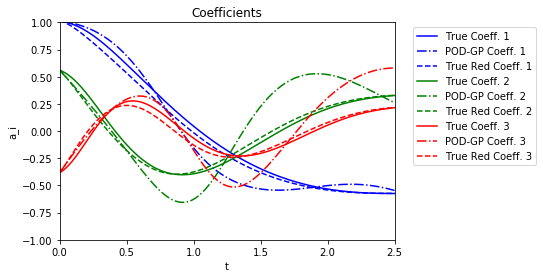

In [15]:
diff_colors = ['b', 'g', 'r', 'k', 'c', 'm']

fig = plt.figure(figsize=(6, 4), facecolor='white')
ax = fig.add_subplot(111)

ax.cla()
ax.set_title('Coefficients')
ax.set_xlabel('t')
ax.set_ylabel('a_i')
ax.set_xlim(min(tf.concat([t, val_t], axis=0).numpy()), max(tf.concat([t, val_t], axis=0).numpy()))
ax.set_ylim(-1, 1)

for i in range(args.rom_dims):
    ax.plot(tf.concat([t, val_t], axis=0).numpy(), tf.concat([true_ai, val_true_ai], axis=0)[:, 0, i], diff_colors[i % args.rom_dims]+'-', label = 'True Coeff. '+str(i+1))
    ax.plot(tf.concat([t, val_t], axis=0).numpy(), tf.concat([ai, val_ai], axis=0)[:, 0, i], diff_colors[i % args.rom_dims]+'-.', label = 'POD-GP Coeff. '+str(i+1))
    ax.plot(tf.concat([t, val_t], axis=0).numpy(), tf.concat([true_ai_red, val_true_ai_red], axis=0)[:, 0, i], diff_colors[i % args.rom_dims]+'--', label = 'True Red Coeff. '+str(i+1))

ax.legend(bbox_to_anchor=(1.04,1), loc="upper left")
plt.show() 

In [16]:
val_true_ai_pert = []

for i in tqdm(range(args.num_ens_mem)):
    
    mean = true_ai_red[-1, 0, :].numpy()
    cov = np.diag(np.repeat(args.std_dev**2, args.rom_dims))
    s = np.random.multivariate_normal(mean, cov, 1)
    
    val_time_new_ic = lambda t: tf.convert_to_tensor(s, tf.float32)
    
    u0_red = red_initial_cond(val_time_new_ic, u_mean, ui)

    u_fom_red_ic = ddeinttf(adeq.ad_eqn(op), u0_red, val_t)
    
    val_true_ai_pert_tmp = u_fom_red_ic - tf.tile(tf.expand_dims(tf.transpose(u_mean, perm=[1, 0]), axis=0), [n_val, args.multi_solve_size, 1])
    val_true_ai_pert_tmp = tf.cast(tf.einsum('ab, cda -> cdb', tf.cast(ui, tf.float64), tf.cast(val_true_ai_pert_tmp, tf.float64)), tf.float32)

    val_true_ai_pert.append(val_true_ai_pert_tmp)
    
val_true_ai_pert = tf.concat(val_true_ai_pert, axis=1)

 10%|█         | 2/20 [02:35<22:34, 75.26s/it]/home/abhinavgupta0110/anaconda3/lib/python3.7/site-packages/scipy/integrate/_ode.py:1177: UserWarning: dopri5: larger nsteps is needed
  self.messages.get(istate, unexpected_istate_msg)))
100%|██████████| 20/20 [24:30<00:00, 73.54s/it]


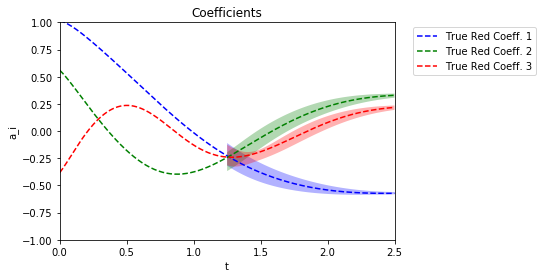

In [17]:
fig = plt.figure(figsize=(6, 4), facecolor='white')
ax = fig.add_subplot(111)

ax.cla()
ax.set_title('Coefficients')
ax.set_xlabel('t')
ax.set_ylabel('a_i')
ax.set_xlim(min(tf.concat([t, val_t], axis=0).numpy()), max(tf.concat([t, val_t], axis=0).numpy()))
ax.set_ylim(-1, 1)

val_mean = np.mean(val_true_ai_pert, axis=1)
val_std = np.std(val_true_ai_pert, axis=1)

for i in range(args.rom_dims):
    ax.plot(tf.concat([t, val_t], axis=0).numpy(), tf.concat([true_ai_red, val_true_ai_red], axis=0)[:, 0, i], diff_colors[i % args.rom_dims]+'--', label = 'True Red Coeff. '+str(i+1))
    ax.fill_between(val_t.numpy(), val_mean[:, i] - val_std[:, i], val_mean[:, i] + val_std[:, i], alpha=0.3, facecolor=diff_colors[i % args.rom_dims])
    
ax.legend(bbox_to_anchor=(1.04,1), loc="upper left")
plt.show() 

In [18]:
whole_true_ai_pert = []

for i in tqdm(range(args.num_ens_mem)):
    
    mean = true_ai_red[0, 0, :].numpy()
    cov = np.diag(np.repeat(args.std_dev**2, args.rom_dims))
    s = np.random.multivariate_normal(mean, cov, 1)
    
    whole_time_new_ic = lambda t: tf.convert_to_tensor(s, tf.float32)
    
    u0_red = red_initial_cond(whole_time_new_ic, u_mean, ui)

    u_fom_red_ic = ddeinttf(adeq.ad_eqn(op), u0_red, tf.concat([t, val_t], axis=0))
    
    whole_true_ai_pert_tmp = u_fom_red_ic - tf.tile(tf.expand_dims(tf.transpose(u_mean, perm=[1, 0]), axis=0), [args.nt + n_val, args.multi_solve_size, 1])
    whole_true_ai_pert_tmp = tf.cast(tf.einsum('ab, cda -> cdb', tf.cast(ui, tf.float64), tf.cast(whole_true_ai_pert_tmp, tf.float64)), tf.float32)

    whole_true_ai_pert.append(whole_true_ai_pert_tmp)
    
whole_true_ai_pert = tf.concat(whole_true_ai_pert, axis=1)

  0%|          | 0/20 [00:00<?, ?it/s]/home/abhinavgupta0110/anaconda3/lib/python3.7/site-packages/scipy/integrate/_ode.py:1177: UserWarning: dopri5: larger nsteps is needed
  self.messages.get(istate, unexpected_istate_msg)))
100%|██████████| 20/20 [1:05:31<00:00, 196.57s/it]


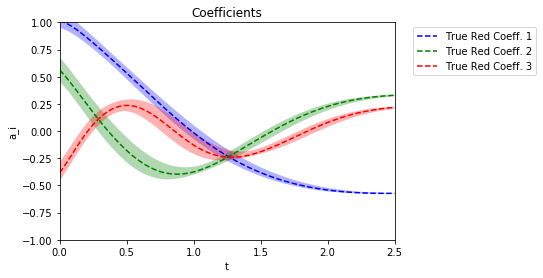

In [19]:
fig = plt.figure(figsize=(6, 4), facecolor='white')
ax = fig.add_subplot(111)

ax.cla()
ax.set_title('Coefficients')
ax.set_xlabel('t')
ax.set_ylabel('a_i')
ax.set_xlim(min(tf.concat([t, val_t], axis=0).numpy()), max(tf.concat([t, val_t], axis=0).numpy()))
ax.set_ylim(-1, 1)

whole_mean = np.mean(whole_true_ai_pert, axis=1)
whole_std = np.std(whole_true_ai_pert, axis=1)

for i in range(args.rom_dims):
    ax.plot(tf.concat([t, val_t], axis=0).numpy(), tf.concat([true_ai_red, val_true_ai_red], axis=0)[:, 0, i], diff_colors[i % args.rom_dims]+'--', label = 'True Red Coeff. '+str(i+1))
    ax.fill_between(tf.concat([t, val_t], axis=0).numpy(), whole_mean[:, i] - whole_std[:, i], whole_mean[:, i] + whole_std[:, i], alpha=0.3, facecolor=diff_colors[i % args.rom_dims])
    
ax.legend(bbox_to_anchor=(1.04,1), loc="upper left")
plt.show()